In [1]:
import pandas as pd
import numpy as np
from graph_tool.all import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.cm
import os
import json
from itertools import combinations

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
VISUALIZATION_DIR = './visualizations/'
ALL_FEATURE_DIR = './data/all_features/'

CHAMP_NETWORK_DIR = './data/data'

## Load data

### Mid-elo data

In [3]:
REGION = 'euw1'
TIER = 'GOLD'
DIVISION = 'I'

In [4]:
gold_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [5]:
REGION = 'kr'
TIER = 'GOLD'
DIVISION = 'I'

In [6]:
gold_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [7]:
# merge
mid_elo = pd.concat([gold_eu, gold_kr], axis=0)

In [8]:
mid_elo = mid_elo[['metadata_match_id', 'puuid', 'units', 'placement', 'win']]

In [9]:
mid_elo.shape

(139824, 5)

In [10]:
mid_elo['unit_name'] = mid_elo['units'].apply(lambda x: set([i['unit_name'] for i in x]))

### High-elo data

Challenger

In [11]:
REGION = 'euw1'
TIER = 'CHALLENGER'
DIVISION = 'I'

In [12]:
chal_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [13]:
REGION = 'kr'
TIER = 'CHALLENGER'
DIVISION = 'I'

In [14]:
chal_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

Grandmaster

In [15]:
REGION = 'euw1'
TIER = 'GRANDMASTER'
DIVISION = 'I'

In [16]:
gm_eu = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

In [17]:
REGION = 'kr'
TIER = 'GRANDMASTER'
DIVISION = 'I'

In [18]:
gm_kr = pd.read_parquet(os.path.join(ALL_FEATURE_DIR, f'all_features_{REGION}_{TIER}_{DIVISION}.parquet'))

Merge

In [19]:
high_elo = pd.concat([chal_eu, chal_kr, gm_eu, gm_kr], axis=0)

In [20]:
high_elo = high_elo[['metadata_match_id', 'puuid', 'units', 'placement', 'win']]

In [21]:
high_elo.shape

(198496, 5)

In [22]:
high_elo['unit_name'] = high_elo['units'].apply(lambda x: set([i['unit_name'] for i in x]))

## Load reference data

In [26]:
# create the vertices - all units from set 13
DATA_DRAGON_DIR = './data/data_dragon/set13/'

In [27]:
with open(os.path.join(DATA_DRAGON_DIR, 'units.json'), 'r') as file:
    units = json.load(file)

In [28]:
SET13_UNITS = [units[i]['name'] for i in units]

In [29]:
unit_costs = {units[i]['name']: units[i]['tier'] for i in units}

## Create network

In [19]:
# initialize empty graph
g_mid = Graph(directed=False)
g_high = Graph(directed=False)

In [21]:
# Add a vertex property map to store names
vname_mid = g_mid.new_vp("string")
vname_high = g_high.new_vp("string")

# add vertices to the graph and add vertex property
for unit in SET13_UNITS:
    v = g_mid.add_vertex()
    vname_mid[v] = unit

    v = g_high.add_vertex()
    vname_high[v] = unit

# Attach the property to the graph
g_mid.vp["name"] = vname_mid
g_high.vp["name"] = vname_high

In [22]:
unit_vertices_mid = {g_mid.vp['name'][v]: v for v in g_mid.vertices()}
unit_vertices_high = {g_high.vp['name'][v]: v for v in g_high.vertices()}

In [23]:
# add edges to graph
def create_edges(unit_list):
    unit_list = set([i for i in unit_list if i in SET13_UNITS])    # exclude summon units
    return [(u1, u2) for (u1, u2) in combinations(unit_list, 2)]

In [24]:
# create edge property for weight
eweight_mid = g_mid.new_edge_property('int')
eweight_high = g_high.new_edge_property('int')

In [25]:
def add_weighted_edges_from_edgelist(g, eweight, edge_list, weight=1):
    for (unit1, unit2) in edge_list:
        unit_vertices = {g.vp['name'][v]: v for v in g.vertices()}
        # get vertex indices of units
        (v1, v2) = (unit_vertices[unit1], unit_vertices[unit2])
        # check if edge already exists
        edge_ = g.edge(v1, v2) or g.edge(v2, v1)
        if edge_:
            eweight[(v1, v2)] += weight  # Increase weight if edge exists
        else:
            edge_ = g.add_edge(v1, v2)  # Add new edge
            eweight[edge_] = weight  # Set initial weight

In [26]:
edge_ls_mid = mid_elo['unit_name'].apply(create_edges)
edge_ls_high = high_elo['unit_name'].apply(create_edges)

In [40]:
for ls in edge_ls_mid:
    add_weighted_edges_from_edgelist(g_mid, eweight_mid, ls)

In [27]:
for ls in edge_ls_high:
    add_weighted_edges_from_edgelist(g_high, eweight_high, ls)

In [28]:
g_mid.ep['weight'] = eweight_mid
g_high.ep['weight'] = eweight_high

## Save networks

In [29]:
g_mid.save(os.path.join(VISUALIZATION_DIR, 'mid_champs.gt'))
g_high.save(os.path.join(VISUALIZATION_DIR, 'high_champs.gt'))

## Load networks

In [30]:
g_mid = graph_tool.load_graph(os.path.join(VISUALIZATION_DIR, 'mid_champs.gt'))
g_high = graph_tool.load_graph(os.path.join(VISUALIZATION_DIR, 'high_champs.gt'))

In [31]:
import cairo

In [32]:
# add champ bg splashart add vertex property
vsurface_mid = g_mid.new_vp('object')
vsurface_high = g_high.new_vp('object')

CHAMP_IMG_DIR = './data/data_visualization_final_project/img/champs/'
# retrieve image link for each champ
unit_images = {units[champ]['name']: cairo.ImageSurface.create_from_png(os.path.join(CHAMP_IMG_DIR, units[champ]['image']['full'])) for champ in units}

for v in g_mid.vertices():
    vsurface_mid[v] = unit_images[g_mid.vp['name'][v]]

for v in g_high.vertices():
    vsurface_high[v] = unit_images[g_high.vp['name'][v]]

g_mid.vp['image'] = vsurface_mid
g_high.vp['image'] = vsurface_high

## Adding more properties to vertices

In [33]:
vcolor_mid = g_mid.new_vp('vector<double>')
vcolor_high = g_high.new_vp('vector<double>')

In [34]:

for v in g_mid.vertices():
    if unit_costs[g_mid.vp.name[v]] == 1:
        vcolor_mid[v] = (0.5, 0.5, 0.5, 0.9)
    elif unit_costs[g_mid.vp.name[v]] == 2:
        vcolor_mid[v] = (0.0, 1.0, 0.0, 0.9)
    elif unit_costs[g_mid.vp.name[v]] == 3:
        vcolor_mid[v] = (0.0, 0.0, 1.0, 0.9)
    elif unit_costs[g_mid.vp.name[v]] == 4:
        vcolor_mid[v] = (0.5, 0.0, 0.5, 0.9)
    elif unit_costs[g_mid.vp.name[v]] == 5:
        vcolor_mid[v] = (1.0, 0.647, 0.0, 0.9)
    else:
        vcolor_mid[v] = (1.0, 0.0, 0.0, 0.9)

g_mid.vp['color'] = vcolor_mid

In [35]:

for v in g_high.vertices():
    if unit_costs[g_high.vp.name[v]] == 1:
        vcolor_high[v] = (0.5, 0.5, 0.5, 0.9)
    elif unit_costs[g_high.vp.name[v]] == 2:
        vcolor_high[v] = (0.0, 1.0, 0.0, 0.9)
    elif unit_costs[g_high.vp.name[v]] == 3:
        vcolor_high[v] = (0.0, 0.0, 1.0, 0.9)
    elif unit_costs[g_high.vp.name[v]] == 4:
        vcolor_high[v] = (0.5, 0.0, 0.5, 0.9)
    elif unit_costs[g_high.vp.name[v]] == 5:
        vcolor_high[v] = (1.0, 0.647, 0.0, 0.9)
    else:
        vcolor_high[v] = (1.0, 0.0, 0.0, 0.9)

g_high.vp['color'] = vcolor_high

In [36]:
# calculate unit play rate
mid_elo['unit_name'] = mid_elo['unit_name'].apply(lambda x: set(x))

unit_freq_mid = (mid_elo.explode('unit_name')
                 .groupby(['metadata_match_id', 'puuid'])['unit_name'].value_counts().reset_index()
                 .groupby('unit_name')[['metadata_match_id', 'puuid']].count()
                 .drop('metadata_match_id', axis=1)
                 .rename(columns={'puuid': 'play_count'})
            )
unit_freq_mid['play_rate'] = unit_freq_mid['play_count'] / mid_elo.shape[0]

In [37]:
high_elo['unit_name'] = high_elo['unit_name'].apply(lambda x: set(x))

unit_freq_high = (high_elo.explode('unit_name')
                 .groupby(['metadata_match_id', 'puuid'])['unit_name'].value_counts().reset_index()
                 .groupby('unit_name')[['metadata_match_id', 'puuid']].count()
                 .drop('metadata_match_id', axis=1)
                 .rename(columns={'puuid': 'play_count'})
            )
unit_freq_high['play_rate'] = unit_freq_high['play_count'] / high_elo.shape[0]

In [38]:
# calculate unit winrate
unit_wr_mid = mid_elo.explode('unit_name').groupby('unit_name')['win'].mean()
unit_wr_high = high_elo.explode('unit_name').groupby('unit_name')['win'].mean()

In [39]:
vfreq_mid = g_mid.new_vp('float')

for v in g_mid.vertices():
    vfreq_mid[v] = unit_freq_mid.loc[g_mid.vp.name[v]]['play_rate']

g_mid.vp.frequency = vfreq_mid

In [40]:
vfreq_high = g_high.new_vp('float')

for v in g_high.vertices():
    vfreq_high[v] = unit_freq_high.loc[g_high.vp.name[v]]['play_rate']

g_high.vp.frequency = vfreq_high

## Filter edges

In [41]:
# retain edges with weights >= threshold
threshold = pd.Series(g_mid.ep.weight.fa).quantile(0.90)

efilt_mid = g_mid.new_ep('bool', vals=g_mid.ep.weight.a >= threshold)

u_mid = GraphView(g_mid, efilt=efilt_mid)

In [42]:
threshold = pd.Series(g_high.ep.weight.fa).quantile(0.90)

efilt_high = g_high.new_ep('bool', vals=g_high.ep.weight.a >= threshold)

u_high = GraphView(g_high, efilt=efilt_high)

## Apply block model

In [43]:
from graph_tool.topology import label_largest_component

In [45]:
# set random seed
np.random.seed(42)
graph_tool.seed_rng(42)

In [46]:
state_mid = minimize_nested_blockmodel_dl(g_mid, state_args=dict(recs=[g_mid.ep.weight],
                                                         rec_types=["discrete-geometric"]))

state_high = minimize_nested_blockmodel_dl(g_high, state_args=dict(recs=[g_high.ep.weight],
                                                         rec_types=["discrete-geometric"]))

## Visualize largest component & hierarchical structure

### Mid elo

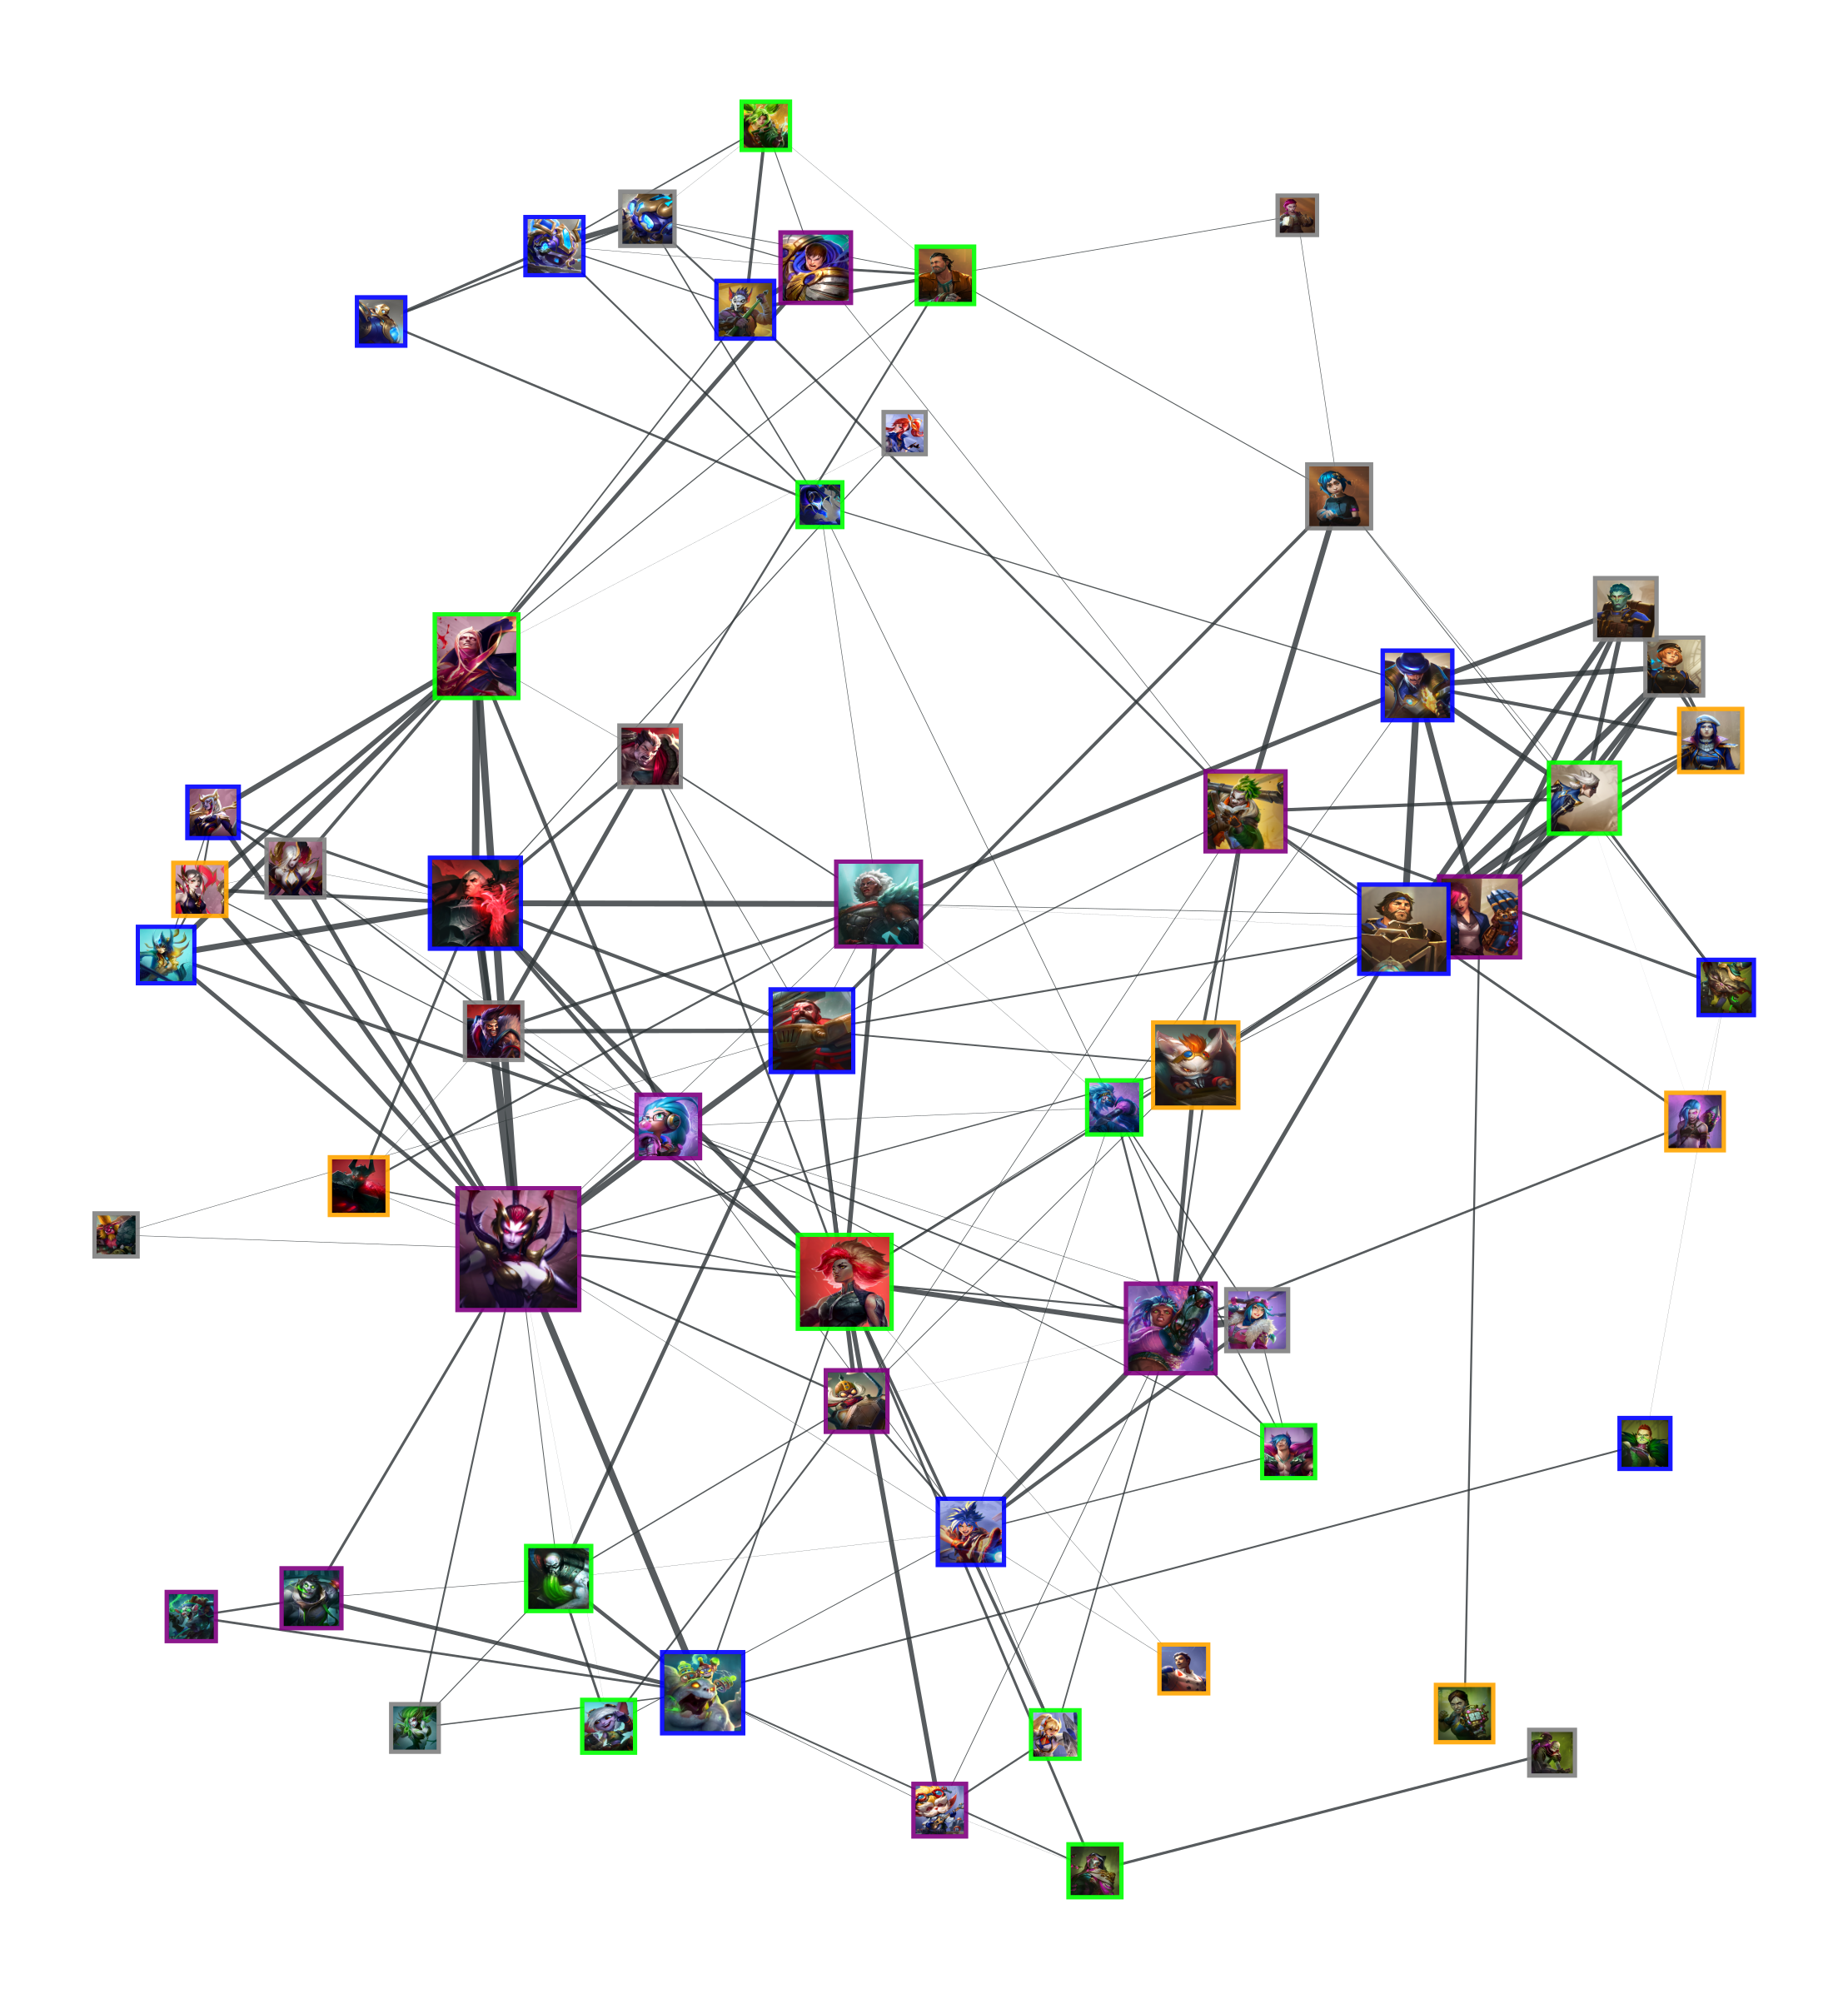

In [77]:
# filter largest component in u
largest_component = label_largest_component(u_mid)
u_mid.set_vertex_filter(largest_component)


pos = arf_layout(u_mid, d=100, a=5)
# pos = radial_tree_layout(u_mid, u_mid.vertex(20))
# pos = sfdp_layout(u, groups=state.project_level(0).get_blocks(), multilevel=True, C=5, r=20)

# edge weight 
edge_weight = prop_to_size(u_mid.ep.weight, mi=0, ma=5, power=1, log=True)
vertex_size = prop_to_size(u_mid.vp.frequency, mi=30, ma=100, power=1)   # scale vertex by play rate
# vertex_size = prop_to_size(u.vp.winrate, mi=20, ma=100, power=1)       # scale vertex by winrate
vertex_label = u_mid.vp.name

# state.draw()
graph_draw(u_mid, pos=pos,
           vertex_shape='square',
           vertex_size=vertex_size,  # Apply eigenvector for vertex size
           vertex_fill_color=u_mid.vp.color,
           vertex_surface=u_mid.vp.image,
           vertex_color=u_mid.vp.color,
           vertex_pen_width=5,
           vorder=g_mid.vp.frequency,
           edge_pen_width=edge_weight,
           eorder=g_mid.ep.weight,
           output_size=(1200, 1200),
           # output=os.path.join(VISUALIZATION_DIR, 'champs_mid.pdf'),
      );

In [68]:
state_mid.draw(edge_gradient=[],  # needed to turn-off the group-based gradients on the edges
           edge_color=prop_to_size(g_mid.ep.weight, power=1, log=False),
           ecmap=matplotlib.cm.inferno,
           eorder=g_mid.ep.weight, # edge ordering is important!
           edge_pen_width=2,
           vcmap=matplotlib.cm.Set1,
           vertex_text=g_mid.vp.name,
           vertex_text_position='centered',
           # vertex_text_font_size=8,
           vertex_size=15,
           output=os.path.join(VISUALIZATION_DIR, 'champs_block_mid.pdf'),
          )

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fabc9b7c3a0, at 0x7fabd6875390>,
 <GraphView object, directed, with 67 vertices and 66 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fabd6875630, at 0x7fabd5f5cd00>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fabd6875630, at 0x7fabd5f5c250>, False), at 0x7fabd6875630>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fabd6875630, at 0x7fabd5f5c880>)

### High elo

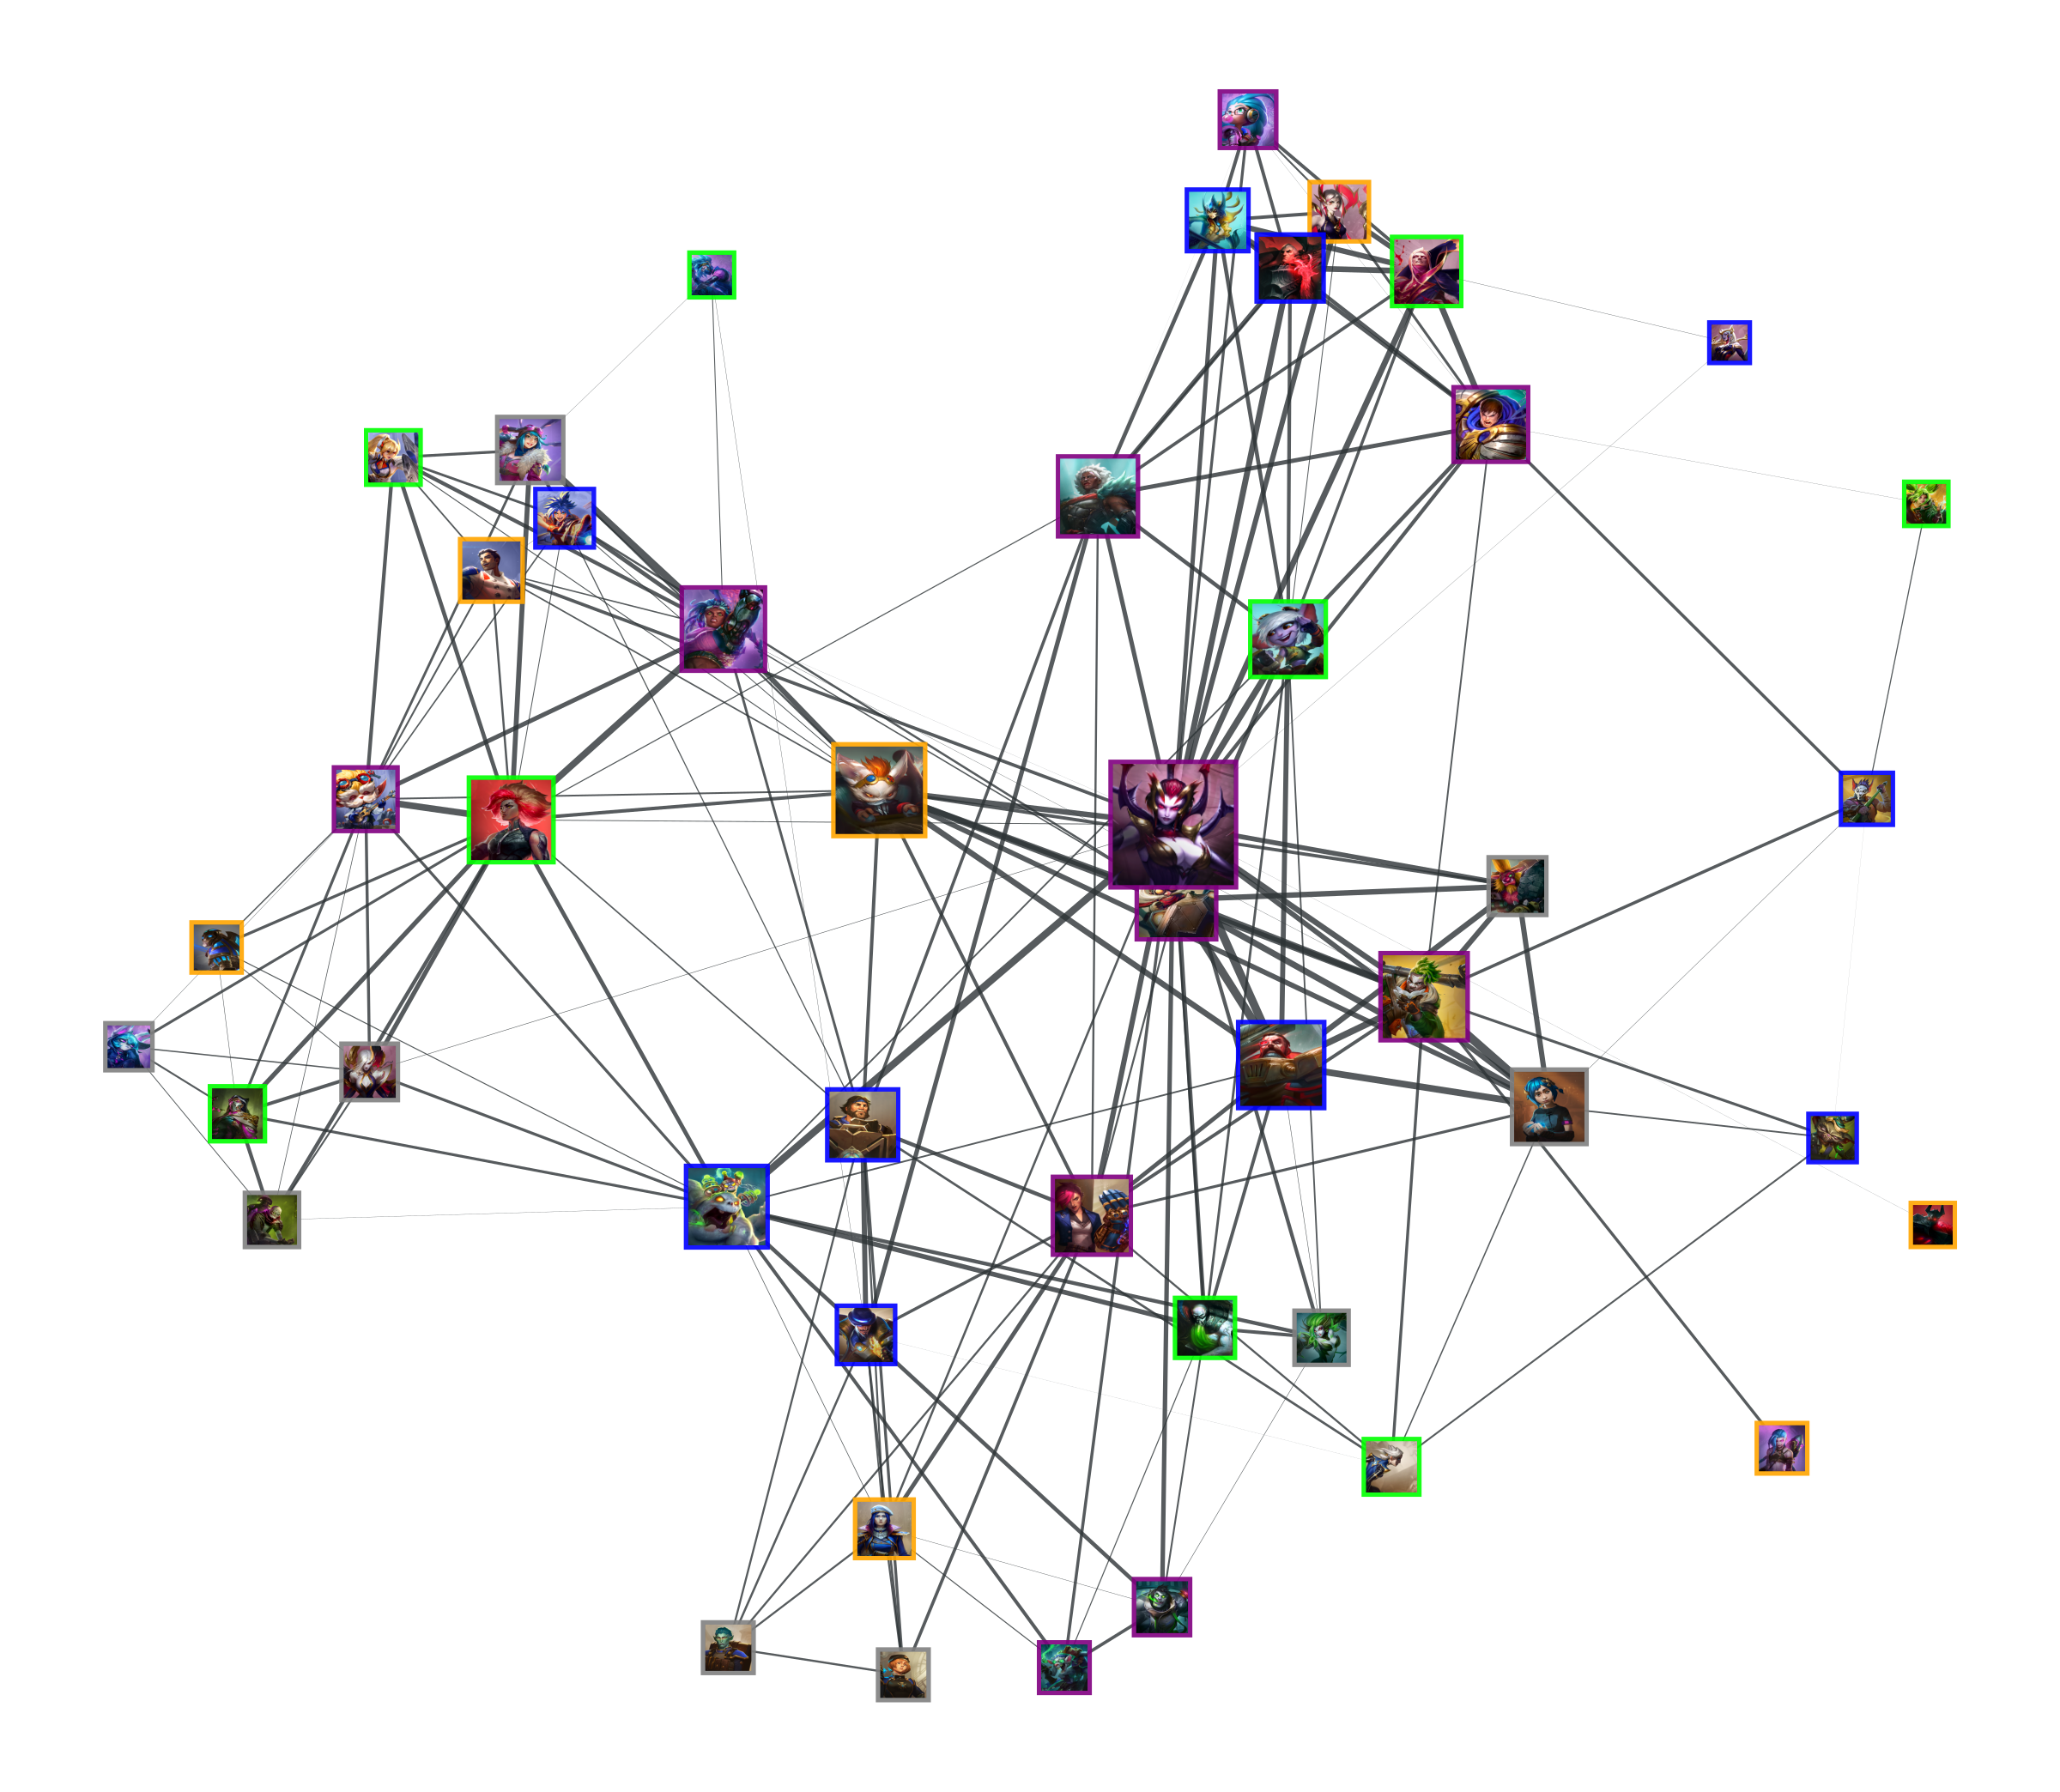

In [78]:
# filter largest component in u
largest_component = label_largest_component(u_high)
u_high.set_vertex_filter(largest_component)


pos = arf_layout(u_high, d=100, a=5)
# pos = radial_tree_layout(u_mid, u_mid.vertex(20))
# pos = sfdp_layout(u_high, groups=state_high.project_level(0).get_blocks(), multilevel=True, C=5, r=20)

# edge weight 
edge_weight = prop_to_size(u_high.ep.weight, mi=0, ma=5, power=1, log=True)
vertex_size = prop_to_size(u_high.vp.frequency, mi=30, ma=100, power=1)   # scale vertex by play rate
# vertex_size = prop_to_size(u.vp.winrate, mi=20, ma=100, power=1)       # scale vertex by winrate
vertex_label = u_high.vp.name

# state.draw()
graph_draw(u_high, pos=pos,
           vertex_shape='square',
           vertex_size=vertex_size,  # Apply eigenvector for vertex size
           vertex_fill_color=u_high.vp.color,
           vertex_surface=u_high.vp.image,
           vertex_color=u_high.vp.color,
           vertex_pen_width=5,
           vorder=g_high.vp.frequency,
           edge_pen_width=edge_weight,
           eorder=g_high.ep.weight,
           output_size=(1200, 1200),
           # output=os.path.join(VISUALIZATION_DIR, 'champs_high.pdf'),
      );

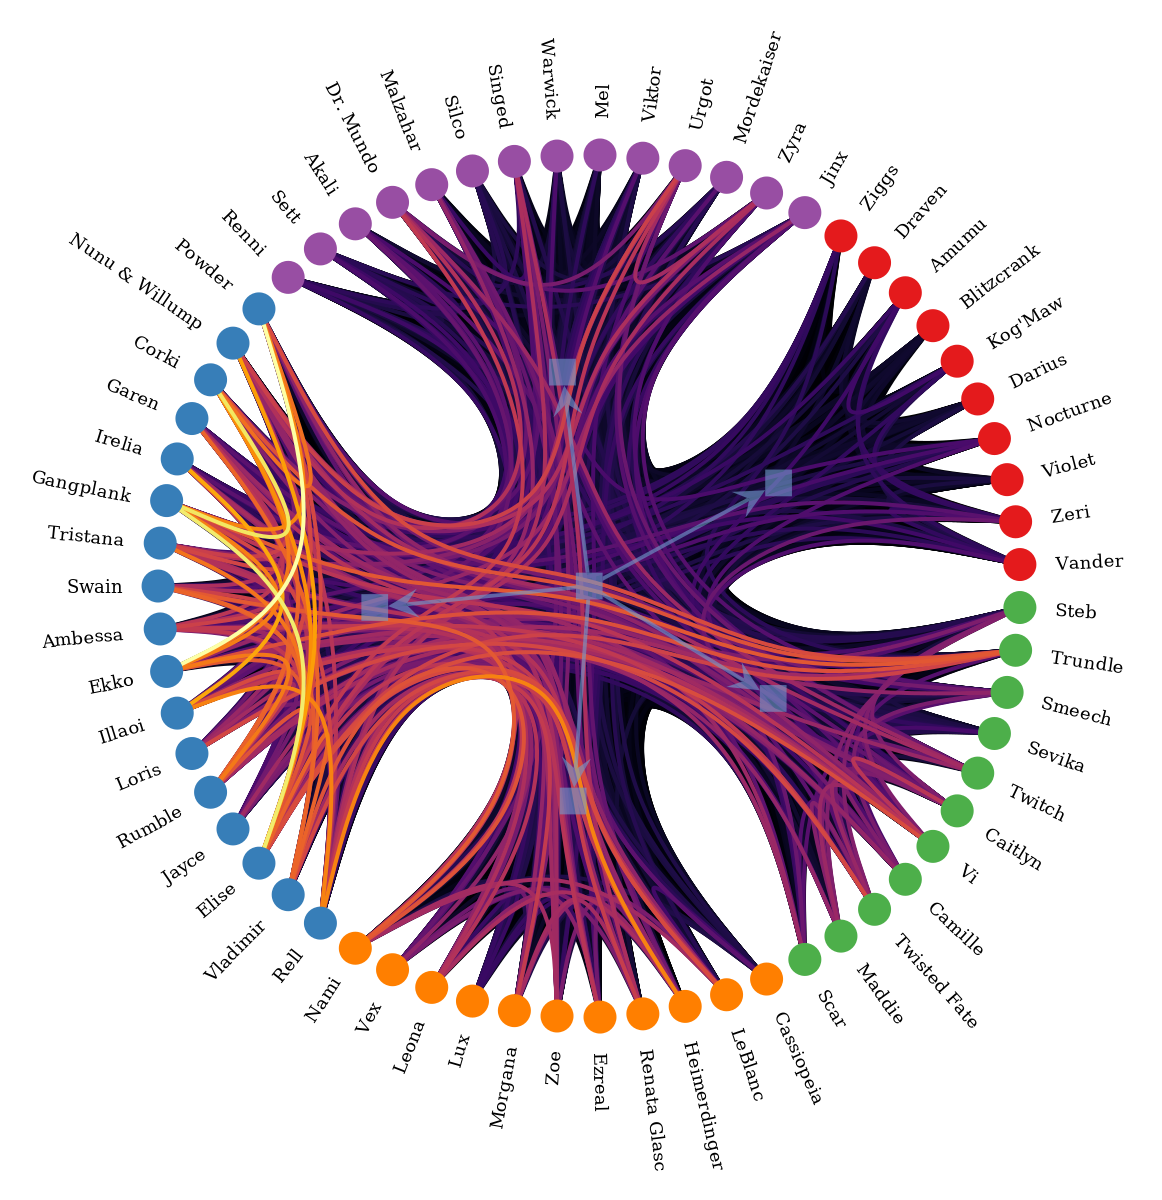

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fabc9b7ca90, at 0x7fabd66b8190>,
 <GraphView object, directed, with 69 vertices and 68 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fabd66ba020, at 0x7fabd66b9ba0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fabd66ba020, at 0x7fabd66b9b40>, False), at 0x7fabd66ba020>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fabd66ba020, at 0x7fabd66b9cf0>)

In [79]:
state_high.draw(edge_gradient=[],  # needed to turn-off the group-based gradients on the edges
           edge_color=prop_to_size(g_high.ep.weight, power=1, log=False),
           ecmap=matplotlib.cm.inferno,
           eorder=g_high.ep.weight, # edge ordering is important!
           edge_pen_width=2,
           vcmap=matplotlib.cm.Set1,
           vertex_text=g_high.vp.name,
           vertex_text_position='centered',
           vertex_size=15,
           # output=os.path.join(VISUALIZATION_DIR, 'champs_block_high.pdf'),
          )

In [84]:
from graph_tool.clustering import global_clustering, local_clustering

In [85]:
global_clustering(g_mid)

(1.0, 0.0)

In [86]:
local_clustering(g_mid)

<VertexPropertyMap object with value type 'double', for Graph 0x7fabc9b7c3a0, at 0x7fabca44e3e0>